In [ ]:
import numpy as np, numpy.random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import preprocessing
import random

import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix
import math
import scipy.stats as st
from sklearn import metrics
from statistics import mean 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from sklearn.model_selection import cross_val_score

from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Get all Matrices from Excel

#FAC_VIEW
dataset_fac_view = pd.read_excel('mfeat-fac.xlsx', header=None)
X_fac = dataset_fac_view.iloc[:, 1:(dataset_fac_view.shape[1])].values


#FOU_VIEW
dataset_fou_view = pd.read_excel('mfeat-fou.xlsx', header=None)
X_fou = dataset_fou_view.iloc[:, 1:(dataset_fou_view.shape[1])].values


#KAR_VIEW
dataset_kar_view = pd.read_excel('mfeat-kar.xlsx', header=None)
X_kar = dataset_kar_view.iloc[:, 1:(dataset_kar_view.shape[1])].values


y = dataset_fac_view.iloc[:, 0].values   #IGUAL PARA TODOS!

print(y)
print(X_fac.shape)
print(X_fou.shape)
print(X_kar.shape)

target = sorted(list(set(y)))                                                    #Classes Rotuladas
print(target)

p = [216, 76, 64]                                                                #fac_view: 216 variables; fou_view: 76 variables; and kar_view: 64 variables

[ 1  1  1 ... 10 10 10]
(2000, 216)
(2000, 76)
(2000, 64)
[1, 2, 3, 4, 6, 7, 8, 9, 10]


In [ ]:
DISTANCE = 'euclidean'
FOLDS = 10
TIMES = 30
SCORING = 'accuracy'
k = 3

In [ ]:
# KNN

def find_best_k(x_train, y_train, DISTANCE, FOLDS):                                                                             
  X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
  k_options = [x for x in range(3, int(math.sqrt(len(y_train)))) if x % 2 != 0]                                                 #[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]
  k = 2
  best_acc = 0
  for n in k_options:
    kfolds = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = 42)
    knn = KNeighborsClassifier(n_neighbors = n, p = 2, metric = DISTANCE)                                                       #p=2 -> Euclidian Distance
    scores = cross_val_score(knn, X_train, y_train, cv = kfolds, scoring = SCORING)
    acc = scores.mean()
    #print (acc, best_acc)
    if acc > best_acc:
      best_acc = acc
      k = n
    else:
      break
  print("k =", k)
  return KNeighborsClassifier(n_neighbors = k, p = 2, metric = DISTANCE)

In [ ]:
# Gauss

def estimate_mean(X_train, y_train, target):                                                                                    
  means = [0 for x in range(len(target))]
  for i in range(len(target)):
    means[i] = [X_train[x].mean(axis=0) for x in np.where(y_train == target[i])][0]
  return means

def estimate_sigmas(X_train, y_train, target, means, d):
  sigmas = [0 for x in range(len(target))]
  for i in range(len(target)):
    x_groupby_class = [X_train[x] for x in np.where(y_train == target[i])][0]
    aux = 0
    for k in range(len(x_groupby_class)):
      aux = aux + np.linalg.norm(x_groupby_class[k] - means[i])**2
    sigmas[i] = aux/(d*len(x_groupby_class))
  return sigmas

def covar_matrix(target, sigmas, d):
  covar = [[] for x in range(len(target))]
  for i in range(len(target)):
    covar[i] = sigmas[i]*np.identity(d, dtype=float)  
  return covar

def verossi_prob(X_test, target, covars, means, d):
  verossi_matrix = []
  for k in range(len(X_test)):
    aux = []
    for i in range(len(target)):
      part1 = np.array([X_test[k] - means[i]])
      part2 = np.linalg.inv(covars[i])
      part3 = np.transpose(np.array([X_test[k] - means[i]]))
      part4 = part1.dot(part2)
      part5 = part4.dot(part3)
      exp = np.exp(-(part5)/2)[0][0]
      vero = ((2*np.pi)**(-d/2))*((np.linalg.det(part2))**(1/2))*exp
      aux.append(vero)
    verossi_matrix.append(aux)
  return verossi_matrix

def poster_prob(X_test, verossi_matrix, target):
  poster_matrix = []
  for k in range(len(X_test)):
      aux = []
      for i in range(len(target)):
        aux.append(verossi_matrix[k][i]/(np.array(verossi_matrix[k]).sum()))
      poster_matrix.append(aux)
  return poster_matrix

In [ ]:
# Parzen

def parzen_window_gaussian(X_train, X_test, y_train, target, h):
  num_test_samples = X_test.shape[0]
  predictions = []
  for i in range(0, num_test_samples):                                           # Adicionei o 0
    x_ = ((X_train - X_test[i, :])**2)**(1/2)                                    # Distancia euclidiana
    x_ = np.exp(-(np.linalg.norm(x_, axis = 1) ** 2) / (2 * h ** 2))
    count = 0
    prediction = target[0]
    for j in target:
      temp = y_train == j
      temp = x_[temp]
      t_ = temp.sum()
      if(t_ > count):
        count = t_
        prediction = j
    predictions.append(prediction)
  return np.array(predictions)

def poster_prob_parzen(classifier_parzen, y_test):
  size = len(classifier_parzen)
  occor = 0
  prob_occor_per_class = []
  for i in range(0, size-1):
    if classifier_parzen[i] == y_test[i]:
      occor = occor + 1
  return (occor / size)

def find_best_h(x_train, y_train, target):
  X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
  h_options = []
  probs_parzen = []
  best_probs_parzen = 0
  for g in range(1, 50+1, 1):
    h_options.append(0.1 * g) 
  for z in h_options:
    classifier_parzen = parzen_window_gaussian(X_train, X_val, y_train, target, z)
    probs_parzen.append(poster_prob_parzen(classifier_parzen, y_val))
    #print(z)
    #print(probs_parzen)
  for l in range(-1, len(probs_parzen)-1, 1):
    if probs_parzen[l+1] > best_probs_parzen:
      position = l+1
      #print(probs_parzen[l+1], best_probs_parzen)
      best_probs_parzen = probs_parzen[l+1]
  h = h_options[position]
  print("h = %.2f" % h)
  return h

In [ ]:
kfolds = StratifiedKFold(n_splits=FOLDS)
means_acc_knn = []
means_acc_gauss = []
means_acc_parzen = []

for n in range(TIMES):
  means_knn = []
  means_gauss = []
  means_parzen = []
  kfolds = StratifiedKFold(n_splits = FOLDS, shuffle = True)

  for train_index, test_index in kfolds.split(X_fac, y):
    y_train, y_test = y[train_index], y[test_index]

    ### FAC_VIEW ###

    print('FAC VIEW, TIME:', n+1)
    X_train_fac, X_test_fac = X_fac[train_index], X_fac[test_index]                                                                #Dividindo os dados
    scaler_fac = StandardScaler()                                                                                                  #Normalizando
    scaler_fac.fit(X_train_fac)
    X_train_fac = scaler_fac.transform(X_train_fac)                                      
    X_test_fac = scaler_fac.transform(X_test_fac)                                                                                        

    # KNN                                                                                                                                 
    classifier_knn_fac = find_best_k(X_train_fac, y_train, DISTANCE, FOLDS)                                                            #Treinamento e Previsões
    best_knn_fac = classifier_knn_fac.fit(X_train_fac, y_train)                                                                        #Ajusta o modelo usando X como dados de treinamento e y como valores alvo
    probs_knn_fac = best_knn_fac.predict_proba(X_test_fac)                                                                         #Retorna estimativas de probabilidade para os dados de teste X

    # GAUSS
    means_fac = estimate_mean(X_train_fac, y_train, target)
    sigmas_fac = estimate_sigmas(X_train_fac, y_train, target, means_fac, p[0])
    covar_fac = covar_matrix(target, sigmas_fac, p[0])
    vero_fac = verossi_prob(X_test_fac, target, covar_fac, means_fac, p[0])
    probs_gauss_fac = poster_prob(X_test_fac, vero_fac, target)
    
    #PARZEN
    best_h_fac = find_best_h(X_train_fac, y_train, target)
    classifier_parzen_fac = parzen_window_gaussian(X_train_fac, X_test_fac, y_train, target, best_h_fac)
    probs_parzen_fac = poster_prob_parzen(classifier_parzen_fac, y_test)


    ### FOU_VIEW ###

    print('FOU VIEW, TIME:', n+1)
    X_train_fou, X_test_fou = X_fou[train_index], X_fou[test_index]                                                                #Dividindo os dados
    scaler_fou = StandardScaler()                                                                                                  #Normalizando
    scaler_fou.fit(X_train_fou)
    X_train_fou = scaler_fou.transform(X_train_fou)                                      
    X_test_fou = scaler_fou.transform(X_test_fou)                                                                                        

    # KNN                                                                                                                                   
    classifier_knn_fou = find_best_k(X_train_fou, y_train, DISTANCE, FOLDS)                                                            #Treinamento e Previsões
    best_knn_fou = classifier_knn_fou.fit(X_train_fou, y_train)                                                                        #Ajusta o modelo usando X como dados de treinamento e y como valores alvo
    probs_knn_fou = best_knn_fou.predict_proba(X_test_fou)                                                                         #Retorna estimativas de probabilidade para os dados de teste X
    
    # GAUSS
    means_fou = estimate_mean(X_train_fou, y_train, target)
    sigmas_fou = estimate_sigmas(X_train_fou, y_train, target, means_fou, p[1])
    covar_fou = covar_matrix(target, sigmas_fou, p[1])
    vero_fou = verossi_prob(X_test_fou, target, covar_fou, means_fou, p[1])
    probs_gauss_fou = poster_prob(X_test_fou, vero_fou, target)

    #PARZEN
    best_h_fou = find_best_h(X_train_fou, y_train, target)
    classifier_parzen_fou = parzen_window_gaussian(X_train_fou, X_test_fou, y_train, target, best_h_fou)
    probs_parzen_fou = poster_prob_parzen(classifier_parzen_fou, y_test)


    ### KAR_VIEW ###

    print('KAR VIEW, TIME:', n+1)
    X_train_kar, X_test_kar = X_kar[train_index], X_kar[test_index]                                                                #Dividindo os dados
    scaler_kar = StandardScaler()                                                                                                  #Normalizando
    scaler_kar.fit(X_train_kar)
    X_train_kar = scaler_kar.transform(X_train_kar)                                      
    X_test_kar = scaler_kar.transform(X_test_kar)                                                                                        

    # KNN                                                                                                                                   
    classifier_knn_kar = find_best_k(X_train_kar, y_train, DISTANCE, FOLDS)                                                            #Treinamento e Previsões
    best_knn_kar = classifier_knn_kar.fit(X_train_kar, y_train)                                                                        #Ajusta o modelo usando X como dados de treinamento e y como valores alvo
    probs_knn_kar = best_knn_kar.predict_proba(X_test_kar)                                                                         #Retorna estimativas de probabilidade para os dados de teste X
    
    # GAUSS
    means_kar = estimate_mean(X_train_kar, y_train, target)
    sigmas_kar = estimate_sigmas(X_train_kar, y_train, target, means_kar, p[2])
    covar_kar = covar_matrix(target, sigmas_kar, p[2])
    vero_kar = verossi_prob(X_test_kar, target, covar_kar, means_kar, p[2])
    probs_gauss_kar = poster_prob(X_test_kar, vero_kar, target)
    
    #PARZEN
    best_h_kar = find_best_h(X_train_kar, y_train, target)
    classifier_parzen_kar = parzen_window_gaussian(X_train_kar, X_test_kar, y_train, target, best_h_kar)
    probs_parzen_kar = poster_prob_parzen(classifier_parzen_kar, y_test)


    ### REGRA DA SOMA ###

    # KNN
    probs_knn = probs_knn_fac + probs_knn_fou + probs_knn_kar
    matrix_knn = pd.DataFrame(probs_knn)
    matrix_knn = matrix_knn.idxmax(axis=1)                                                                                          #Get row index label or position of maximum values of every column
    y_predict_knn = list(map(lambda x: target[x], matrix_knn))
    means_knn.append(metrics.accuracy_score(y_test, y_predict_knn))
    #print("KNN %.2f" % means_knn)

    # GAUSS
    probs_gauss = np.array(probs_gauss_fac) + np.array(probs_gauss_fou) + np.array(probs_gauss_kar)
    matrix_gauss = pd.DataFrame(probs_gauss)
    matrix_gauss = matrix_gauss.idxmax(axis=1)                                                                                      #Get row index label or position of maximum values of every column
    y_predict_gauss = list(map(lambda x: target[x], matrix_gauss))
    means_gauss.append(metrics.accuracy_score(y_test, y_predict_gauss)) 
    #print("GAUSS %.2f" % means_gauss)

    # PARZEN
    probs_parzen = probs_parzen_fac + probs_parzen_fou + probs_parzen_kar
    #means_parzen.append(metrics.accuracy_score(y_test, y_predict_gauss))
    means_parzen.append(probs_parzen/3)
    #print("PARZEN %.2f" % means_parzen)


  means_acc_knn.append(mean(means_knn))
  print(means_acc_knn)
  means_acc_gauss.append(mean(means_gauss))
  print(means_acc_gauss)
  means_acc_parzen.append(mean(means_parzen))
  print(means_acc_parzen)
  
    #y_pred_fac = classifier_fac.predict(X_test_fac)                                                                               #Prever os rótulos das classes para os dados fornecidos
    #print(confusion_matrix(y_test_fac, y_pred_fac))                                                                               #Avaliando pela matriz de Confusão
    #print(classification_report(y_test_fac, y_pred_fac))

FAC VIEW, TIME: 1
k = 7
h = 4.50
FOU VIEW, TIME: 1
k = 7
h = 2.80
KAR VIEW, TIME: 1
k = 3
h = 2.60
FAC VIEW, TIME: 1
k = 11
h = 4.50
FOU VIEW, TIME: 1
k = 7
h = 2.20
KAR VIEW, TIME: 1
k = 5
h = 2.20
FAC VIEW, TIME: 1
k = 5
h = 4.00
FOU VIEW, TIME: 1
k = 7
h = 2.20
KAR VIEW, TIME: 1
k = 3
h = 2.30
FAC VIEW, TIME: 1
k = 5
h = 4.40
FOU VIEW, TIME: 1
k = 7
h = 2.10
KAR VIEW, TIME: 1
k = 9
h = 1.90
FAC VIEW, TIME: 1
k = 7
h = 2.90
FOU VIEW, TIME: 1
k = 5
h = 2.60
KAR VIEW, TIME: 1
k = 3
h = 1.90
FAC VIEW, TIME: 1
k = 3
h = 4.90
FOU VIEW, TIME: 1
k = 7
h = 2.20
KAR VIEW, TIME: 1
k = 11
h = 2.10
FAC VIEW, TIME: 1
k = 5
h = 4.40
FOU VIEW, TIME: 1
k = 5
h = 1.80
KAR VIEW, TIME: 1
k = 5
h = 2.10
FAC VIEW, TIME: 1
k = 5
h = 4.20
FOU VIEW, TIME: 1
k = 3
h = 1.50
KAR VIEW, TIME: 1
k = 3
h = 1.80
FAC VIEW, TIME: 1
k = 5
h = 3.60
FOU VIEW, TIME: 1
k = 7
h = 2.20
KAR VIEW, TIME: 1
k = 3
h = 2.00
FAC VIEW, TIME: 1
k = 3
h = 4.20
FOU VIEW, TIME: 1
k = 9
h = 1.80
KAR VIEW, TIME: 1
k = 3
h = 2.00
[0.917]


In [ ]:
# Confidence Interval

confidence = 0.95
knn = 1.0 * np.array(means_acc_knn)
n_knn = len(knn)
m_knn, se = np.mean(knn), st.sem(knn)
h_knn = se * st.t.ppf((1 + confidence) / 2., n_knn-1)
print(m_knn - h_knn, m_knn, m_knn + h_knn)

confidence = 0.95
gauss = 1.0 * np.array(means_acc_gauss)
n_gauss = len(gauss)
m_gauss, se = np.mean(gauss), st.sem(gauss)
h_gauss = se * st.t.ppf((1 + confidence) / 2., n_gauss-1)
print(m_gauss - h_gauss, m_gauss, m_gauss + h_gauss)

confidence = 0.95
parzen = 1.0 * np.array(means_acc_parzen)
n_parzen = len(parzen)
m_parzen, se = np.mean(parzen), st.sem(parzen)
h_parzen = se * st.t.ppf((1 + confidence) / 2., n_parzen-1)
print(m_parzen - h_parzen, m_parzen, m_parzen + h_parzen)

0.9163623560353974 0.9172500000000002 0.9181376439646031
0.9091520312718028 0.90965 0.9101479687281971
0.8404866836870309 0.8411444444444444 0.8418022052018578


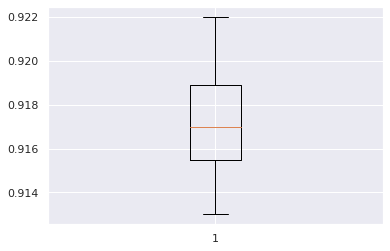

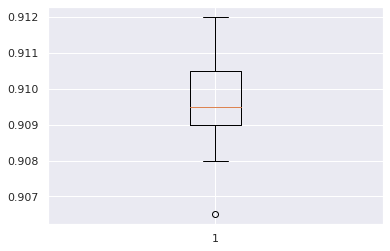

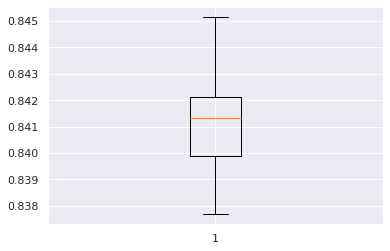

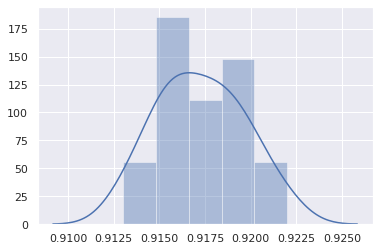

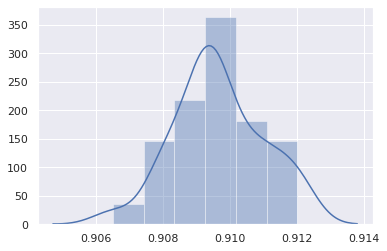

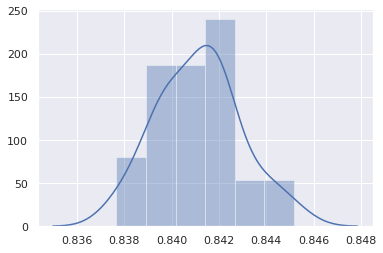

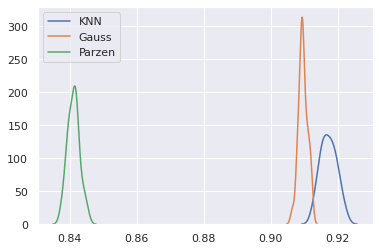

In [ ]:
# Plots

sns.set(color_codes = True)

plt.boxplot(means_acc_knn)
plt.show()    
plt.boxplot(means_acc_gauss)
plt.show()
plt.boxplot(means_acc_parzen)
plt.show()

sns.distplot(means_acc_knn)
plt.show()
sns.distplot(means_acc_gauss)
plt.show()
sns.distplot(means_acc_parzen)
plt.show()
 
sns.kdeplot(means_acc_knn, label="KNN")
sns.kdeplot(means_acc_gauss, label="Gauss")
sns.kdeplot(means_acc_parzen, label="Parzen")
plt.legend()      

In [ ]:
# Friedman test

stat, p = friedmanchisquare(means_acc_knn, means_acc_gauss, means_acc_parzen)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
  print('Same distributions (fail to reject H0)')
else:
  print('Different distributions (reject H0)')

Statistics=60.000, p=0.000
Different distributions (reject H0)
